In [83]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sympy.solvers import solve
from sympy import Symbol

from tqdm import tqdm

from itertools import permutations
import sys

import numpy as np
np.warnings.filterwarnings('ignore')

[-1, 1]

In [117]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1).astype(int)


def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels.astype(int)]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
#     if invert_labels:
#         Y = -1 * (Y - 1)
    
    return X, Y.astype(int)

def generate_box(n, d=2, invert_labels=False, acorn=None):
    x = Symbol('x')
    sol = float(max(solve(x**d - 2*(1-x) + (1 - x)**d, x)))
    
    if acorn is not None:
        np.random.seed(acorn)

    X = np.random.uniform(-1, 1, size=(n, d))
    
    Y = -1*np.ones(n)
    
    for i in range(n):
        for dim in range(d):
            if X[i, dim] > sol or X[i, dim] < -sol:
                Y[i] = 1
        if Y[i] == -1:
            Y[i] = 0
                
                
            
            
            
#         if X[i, 0] > 3/4 or X[i, 0] < -3/4 or X[i, 1] > 3/4 or X[i, 1] < -3/4:
#             Y[i]=1
#         else:
#             Y[i]=0
            
#     if invert_labels:
#         Y = -1 * (Y - 1)

    return X, Y.astype(int)

def jovo_experiment(nx, nz, d, dist_x, dist_z, m, target="Z", subsample = 0.32, metric='accuracy',n_algos=6):
    metric_ = getattr(getattr(__import__('sklearn'), 'metrics'), '%s_score'%(metric))
    
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d, invert_labels=invert_x)
    testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)

    
    # Target task
    Z, labelsZ = dist_z(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = metric_(test_labelsX, pred_X) #1 - np.sum(test_labelsX == pred_X)/m
    errors[2] = metric_(test_labelsZ, pred_Z) # (1 - np.sum(test_labelsZ == pred_Z)/m
    
#     errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
#     errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[1] = metric_(test_labelsX, pred_X_jtv) # 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[3] = metric_(test_labelsZ, pred_Z_jtv) # 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # Sum
    X, labelsX = dist_x(nz + nx, d, invert_labels=invert_x)
#     testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)
    
    model_best_X = build_model(X, labelsX, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best_X=estimate_posteriors(model_best_X, X, labelsX, testX, in_task=True)
    predictions_best_X=predict(posteriors_best_X)
    
    errors[4] = metric_(test_labelsX, predictions_best_X) # 1 - np.sum(test_labelsX == predictions_best_X)/m
    
    # Sum
    Z, labelsZ = dist_z(nz + nx, d, invert_labels=invert_z)
#     testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
    model_best_Z = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best_Z=estimate_posteriors(model_best_Z, Z, labelsZ, testZ, in_task=True)
    predictions_best_Z=predict(posteriors_best_Z)
    
    errors[5] = metric_(test_labelsZ, predictions_best_Z) #1 - np.sum(test_labelsZ == predictions_best_Z)/m
    
    return errors

In [118]:
generate_box(100, 2)[1]

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])

In [119]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 4, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forests Source', 'Lifelong Forests Source', 'Optimal Forests Source']
algorithms = np.concatenate((algorithms, ['Decision Forests Target', 'Lifelong Forests Target', 'Optimal Forests Target']))

M = len(algorithms)

mean_precision= np.zeros((M, len(ns)))
std_precision= np.zeros((M, len(ns)))

d = 3
metric = 'precision'
np.random.seed(1)
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, generate_parity, generate_box, m, metric=metric,
                                                n_algos=M)
    
    precisions = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_precision[:, j] = np.mean(precisions, axis=0)
    std_precision[:, j] = np.std(precisions, ddof=1, axis=0)





  0%|          | 0/7 [00:00<?, ?it/s]



 14%|█▍        | 1/7 [00:04<00:29,  4.98s/it]



 29%|██▊       | 2/7 [00:06<00:19,  3.94s/it]



 43%|████▎     | 3/7 [00:08<00:13,  3.32s/it]



 57%|█████▋    | 4/7 [00:10<00:08,  2.99s/it]



 71%|███████▏  | 5/7 [00:13<00:05,  2.83s/it]



 86%|████████▌ | 6/7 [00:15<00:02,  2.82s/it]



100%|██████████| 7/7 [00:19<00:00,  2.96s/it]

In [124]:
mean_recall= np.zeros((M, len(ns)))
std_recall= np.zeros((M, len(ns)))

d = 3
metric = 'recall'
np.random.seed(1)
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, generate_parity, generate_box, m, metric=metric,
                                                n_algos=M)
    
    recalls = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_recall[:, j] = np.mean(recalls, axis=0)
    std_recall[:, j] = np.std(recalls, ddof=1, axis=0)





  0%|          | 0/7 [00:00<?, ?it/s]



 14%|█▍        | 1/7 [00:01<00:09,  1.53s/it]



 29%|██▊       | 2/7 [00:03<00:07,  1.56s/it]



 43%|████▎     | 3/7 [00:05<00:06,  1.66s/it]



 57%|█████▋    | 4/7 [00:07<00:05,  1.84s/it]



 71%|███████▏  | 5/7 [00:09<00:04,  2.02s/it]



 86%|████████▌ | 6/7 [00:12<00:02,  2.26s/it]



100%|██████████| 7/7 [00:15<00:00,  2.57s/it]

In [125]:
mean_accuracy= np.zeros((M, len(ns)))
std_accuracy= np.zeros((M, len(ns)))

d = 3
metric = 'accuracy'
np.random.seed(1)
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, generate_parity, generate_box, m, metric=metric,
                                                n_algos=M)
    
    accuracys = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_accuracy[:, j] = np.mean(accuracys, axis=0)
    std_accuracy[:, j] = np.std(accuracys, ddof=1, axis=0)





  0%|          | 0/7 [00:00<?, ?it/s]



 14%|█▍        | 1/7 [00:01<00:08,  1.37s/it]



 29%|██▊       | 2/7 [00:03<00:07,  1.46s/it]



 43%|████▎     | 3/7 [00:04<00:06,  1.56s/it]



 57%|█████▋    | 4/7 [00:06<00:05,  1.72s/it]



 71%|███████▏  | 5/7 [00:09<00:03,  1.97s/it]



 86%|████████▌ | 6/7 [00:12<00:02,  2.24s/it]



100%|██████████| 7/7 [00:15<00:00,  2.51s/it]

In [126]:
np.random.seed(2)
X, labelsX = generate_parity(500, 2)
temp_labelsX = []

# Target task
Z, labelsZ = generate_box(500, 2, invert_labels=True)
temp_labelsZ = []

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append('k')
    else:
        temp_labelsX.append('pink')
        
    if labelsZ[i] == 0:
        temp_labelsZ.append('k')
    else:
        temp_labelsZ.append('pink')

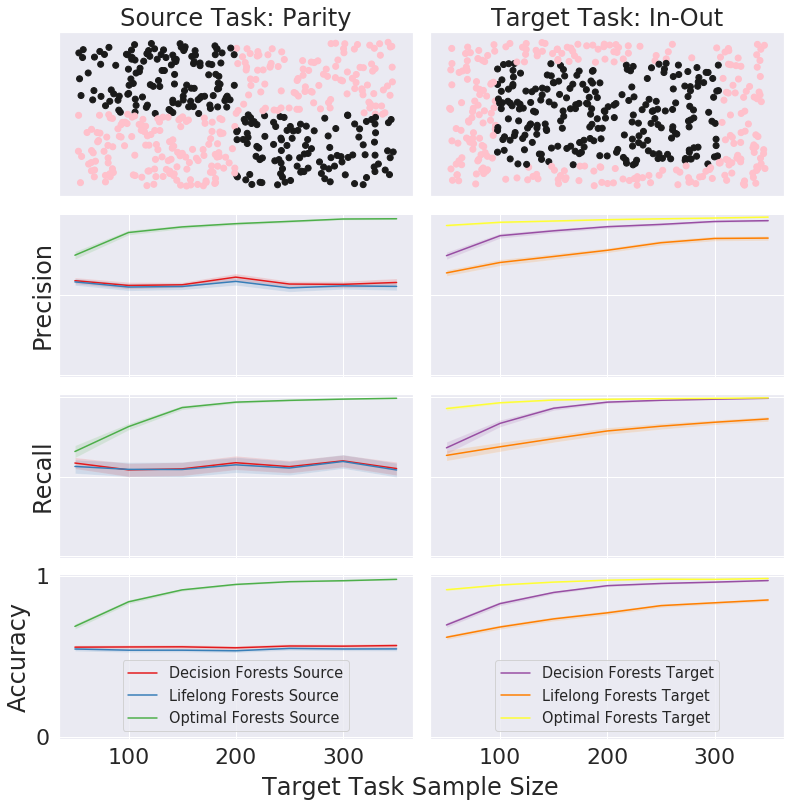

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set(font_scale=2)
colors = sns.color_palette("Set1", n_colors = M)
fig1, ax = plt.subplots(4,2, figsize = (13, 13), sharex = 'row', sharey='row')

ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: In-Out')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
    
ax[1,0].set_ylabel('Precision')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_ylim(0 - 0.01)
ax[1,0].set_ylim(0 - 0.01)

algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[2,0].plot(ns, mean_recall[i + algo_offset], label=algo, c=colors[i])
    ax[2,0].fill_between(ns, 
            mean_recall[i + algo_offset] + 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            mean_recall[i + algo_offset] - 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_recall[i + algo_offset] + 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it) >= mean_recall[i + algo_offset] - 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[2,1].plot(ns, mean_recall[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[2,1].fill_between(ns, 
            mean_recall[i + algo_offset] + 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            mean_recall[i + algo_offset] - 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_recall[i + algo_offset] + 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it) >= mean_recall[i + algo_offset] - 1.96*std_recall[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
    
ax[2,0].set_ylabel('Recall')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[2,0].set_ylim(0 - 0.01)
ax[2,0].set_ylim(0 - 0.01)

algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[3,0].plot(ns, mean_accuracy[i + algo_offset], label=algo, c=colors[i])
    ax[3,0].fill_between(ns, 
            mean_accuracy[i + algo_offset] + 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            mean_accuracy[i + algo_offset] - 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_accuracy[i + algo_offset] + 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it) >= mean_accuracy[i + algo_offset] - 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[3,1].plot(ns, mean_accuracy[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[3,1].fill_between(ns, 
            mean_accuracy[i + algo_offset] + 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            mean_accuracy[i + algo_offset] - 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_accuracy[i + algo_offset] + 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it) >= mean_accuracy[i + algo_offset] - 1.96*std_accuracy[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
    
ax[3,0].legend(loc='lower center', fontsize=14.5)
ax[3,1].legend(loc='lower center', fontsize=14.5)
    
ax[3,0].set_ylabel('Accuracy')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[3,0].set_ylim(0 - 0.01)
ax[3,0].set_ylim(0 - 0.01)

ax[1,0].tick_params(labelbottom=False, labelleft=False)
ax[2,0].tick_params(labelbottom=False, labelleft=False)
# ax[3,0].tick_params(labelleft=False)

ax[1,1].tick_params(labelbottom=False)
ax[2,1].tick_params(labelbottom=False)
ax[3,1].set_yticks([0,1])

# ax[1,1].set_xticks([])
# ax[2,1].set_xticks([])
# ax[3,1].set_xticks([])

# ax[2,1].set_yticks([])
# ax[3,1].set_yticks([])

fig1.subplots_adjust(wspace=0.05, hspace=0.1)
fig1.text(0.5, 0.065, 'Target Task Sample Size', ha='center')


plt.savefig('PRA_parity_inout_3d_n100.pdf')

In [29]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 4, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forests Source', 'Lifelong Forests Source', 'Optimal Forests Source']
algorithms = np.concatenate((algorithms, ['Decision Forests Target', 'Lifelong Forests Target', 'Optimal Forests Target']))

M = len(algorithms)

mean_precision= np.zeros((M, len(ns)))
std_precision= np.zeros((M, len(ns)))

d = 2
metric = 'recall'
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, generate_parity, generate_box, m, metric=metric,
                                                n_algos=M)
    
    precisions = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_precision[:, j] = np.mean(precisions, axis=0)
    std_precision[:, j] = np.std(precisions, ddof=1, axis=0)


100%|██████████| 7/7 [00:16<00:00,  2.53s/it]

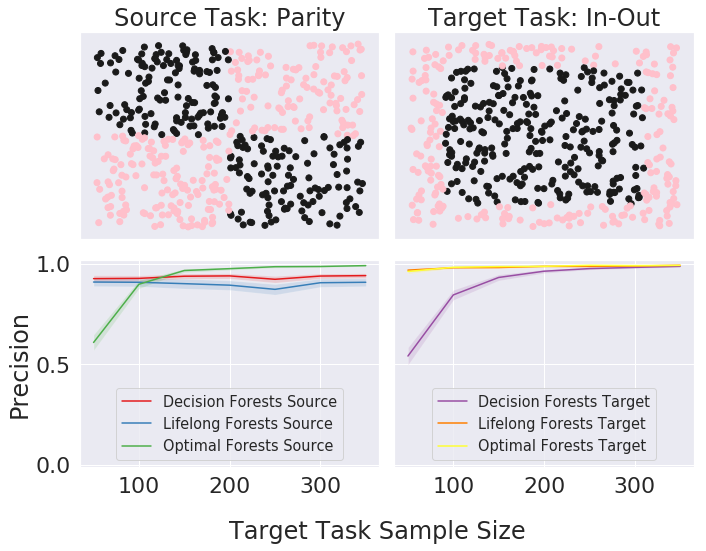

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set(font_scale=2)
colors = sns.color_palette("Set1", n_colors = M)
fig1, ax = plt.subplots(2,2, figsize = (11, 8), sharex = 'row', sharey='row')

ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: In-Out')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
    
ax[1,0].legend(loc='lower center', fontsize=14.5)
ax[1,1].legend(loc='lower center', fontsize=14.5)
ax[1,0].set_ylabel('Precision')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_ylim(0 - 0.01)
ax[1,0].set_ylim(0 - 0.01)

fig1.subplots_adjust(wspace=0.05, hspace=0.1)
fig1.text(0.5, 0, 'Target Task Sample Size', ha='center')


plt.savefig('recall_parity_inout_2d_n100.pdf')

In [33]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 4, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forests Source', 'Lifelong Forests Source', 'Optimal Forests Source']
algorithms = np.concatenate((algorithms, ['Decision Forests Target', 'Lifelong Forests Target', 'Optimal Forests Target']))

M = len(algorithms)

mean_precision= np.zeros((M, len(ns)))
std_precision= np.zeros((M, len(ns)))

d = 2
metric = 'accuracy'
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, generate_parity, generate_box, m, metric=metric,
                                                n_algos=M)
    
    precisions = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_precision[:, j] = np.mean(precisions, axis=0)
    std_precision[:, j] = np.std(precisions, ddof=1, axis=0)



  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:03<00:20,  3.40s/it]

 29%|██▊       | 2/7 [00:04<00:13,  2.77s/it]

 43%|████▎     | 3/7 [00:06<00:09,  2.40s/it]

 57%|█████▋    | 4/7 [00:08<00:06,  2.25s/it]

 71%|███████▏  | 5/7 [00:10<00:04,  2.20s/it]

 86%|████████▌ | 6/7 [00:12<00:02,  2.31s/it]

100%|██████████| 7/7 [00:15<00:00,  2.45s/it]

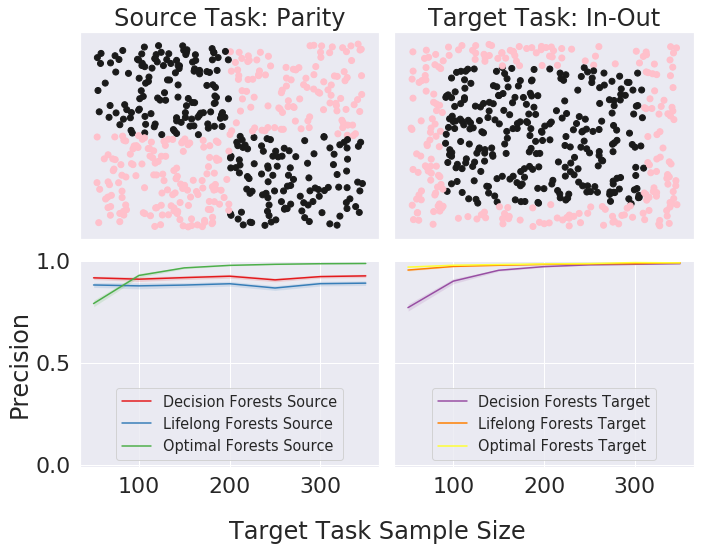

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set(font_scale=2)
colors = sns.color_palette("Set1", n_colors = M)
fig1, ax = plt.subplots(2,2, figsize = (11, 8), sharex = 'row', sharey='row')

ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: In-Out')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_precision[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_precision[i + algo_offset] + 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it) >= mean_precision[i + algo_offset] - 1.96*std_precision[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
    
ax[1,0].legend(loc='lower center', fontsize=14.5)
ax[1,1].legend(loc='lower center', fontsize=14.5)
ax[1,0].set_ylabel('Precision')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_ylim(0 - 0.01)
ax[1,0].set_ylim(0 - 0.01)

fig1.subplots_adjust(wspace=0.05, hspace=0.1)
fig1.text(0.5, 0, 'Target Task Sample Size', ha='center')


plt.savefig('accuracy_parity_inout_2d_n100.pdf')